# Plot Profile Normalization and Analysis

The following script will normalize and graph plot profile data from either one condition of data or all conditions (ex. if you have plot profiles for wt condition and for a mutant condition). 

### Creating Plot Profiles with Fiji
Plot profile files can be created using Fiji/ImageJ (Draw line on image, Analyze->Plot Profile, Data->Save Data). Fiji saves these plot profile files in .csv format, with 2 columns of data (Distance_(microns) and Gray_Value), therefore this script assumes all files are .csv format. When saving the plot profile files, use the same name for each file (ex. Values.csv or Values_C1.csv) and save the file in an individual folder for each image analyzed (ex. if you have 10 images, created 10 individual folders in a directory and save the plot profile files into their own folder).


### Opening Prompts
After creating plot profiles, run this script and it will ask you several prompts at the beginning. It will ask you for the number of conditions you intend to analyze. Then it will ask you for the name of each condition, it is essential that the name of the directory holding the plot profile folders is the condition name. For example, if you have 2 conditions (wt vs mutant), label the folder containing the data for wt, 'wt', and label the folder containing the data for mutant, 'mutant'. Then when it prompts you for the name of condition 1, enter 'wt', and for condition 2, enter 'mutant'. Then it will ask you for the name of the plot profile files (remember this should be the same for each individual file and the same across conditions, the default name from Fiji is just 'Values'). If you create multiple plot profiles per image, lets say a plot profile for channel1 and a plot profile for channel2, save all the plot profiles for channel 1 as 'Values_C1' and the plot profiles for channel 2 as 'Values_C2', then when you run this script, if you want to normalize and graph the channel 1 plot profiles, input 'Values_C1' when the script prompts: "What is the name of the plot profile files you want to analyze?". Finally, it will pop up a file explorer window and ask what directory your data is in, if you are analyzing 1 condition, select the directory that contains the individual folders with all your plot profile files, if you are analyzing multiple conditions, select the directory that contains all your condition folders (each condition folder should then contain a folder for each plot profile file you collected). 


### Output Files
This script will output several files in each condition folder: the normalized values (normalized_data_condition_{conditionname}.xlsx), the 95% percentile value for each file (individual_95percentiles_{conditionname}.xlsx), the graph of the normalized plot profiles on a 0-100 point scale with 95% confidence intervals. If you analyzed multiple conditions, it will also output a graph with the normalized data for each condition and save this as a pdf to the directory where all the condition folders are located.


### Troubleshooting
If you are getting empty graphs, double check you are choosing the correct directory and that you are inputing the name of the plot profile names correctly (this is case sensitive). Additionally, if you have extra folders in the directories you are analyzing, this may cause errors, I recommend only having the relevant folders in the directories you are selecting.


### Normalization Process
Y values are normalized by subtracting minimum Y value from all Y-values then dividing by the range of Y (difference between the maximum and minimum values of Y). The same process is down for X. Then interpolation is performed to ensure both X and Y data points have exactly 100 points

### Install necessary python libraries (only need to do this once)

In [1]:
pip install pandas numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


# Plot Profile Normalization Script

Selected directory: C:/Users/oes6098/Desktop/test plot profiles/6.16.23 phalloidin kif5a stbl tub dm1a gen3
Condition:  27del


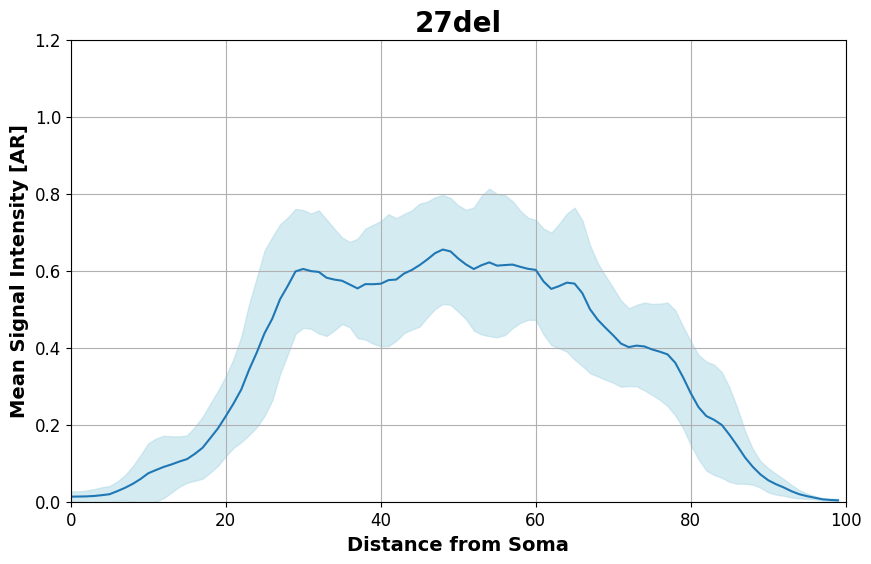

Plot saved as vector image file (PDF): 27del
Condition:  854


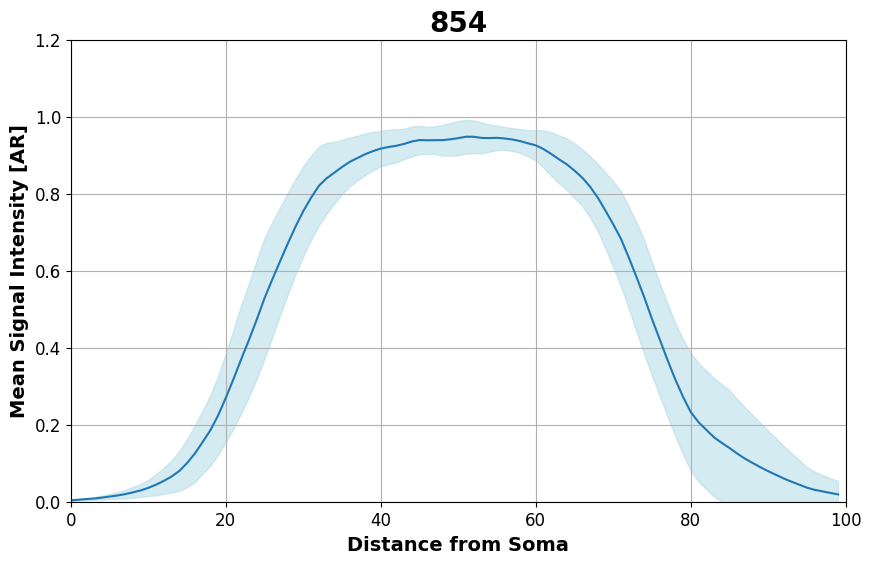

Plot saved as vector image file (PDF): 854
Condition:  wt


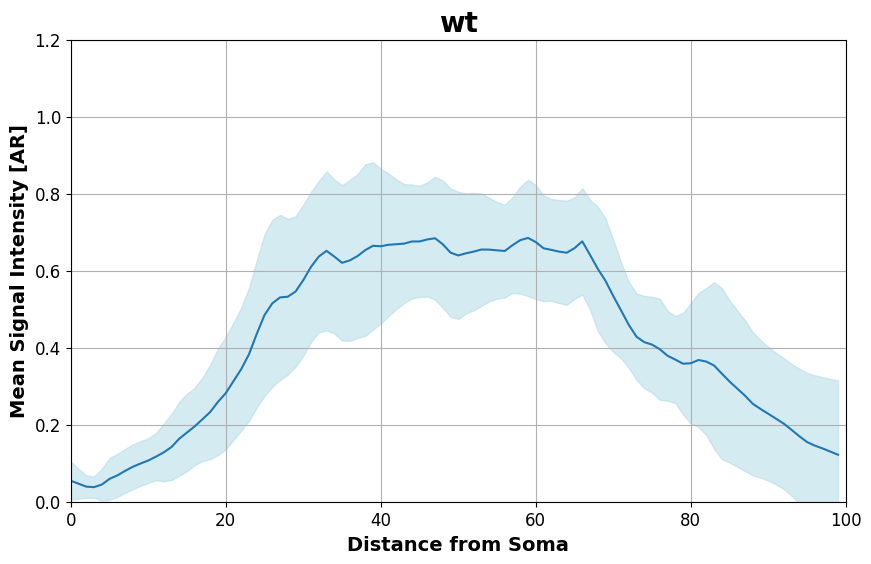

Plot saved as vector image file (PDF): wt


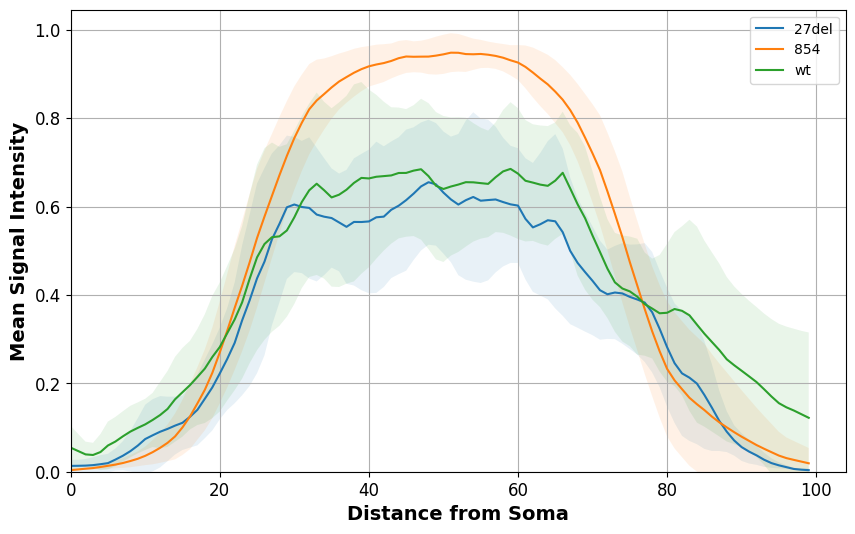

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog

def normalize(filepath, numpoints, foldername, filename, percentilelist, df):
    
    # Import data from CSV file
    data = pd.read_csv(filepath)
    X1 = data.iloc[:, 0]
    Y1 = data.iloc[:, 1]
    
    # Normalize X-values
    Xnorm = (X1 - X1.min()) / (X1.max() - X1.min())
    
    # Normalize Y-values
    Ynorm = (Y1 - Y1.min()) / (Y1.max() - Y1.min())
    
    # Interpolate to ensure exactly num_points values
    Xnorm_interp = np.linspace(0, 1, numpoints)
    Ynorm_interp = np.interp(Xnorm_interp, Xnorm, Ynorm)
    
    # Add normalized Y-values to the dataframe as a new column
    column_name = f"{foldername}_{os.path.splitext(filename)[0]}"
    df[column_name] = Ynorm_interp

    # Calculate the 95th percentile
    ninety_fifth_percentile = np.percentile(Ynorm_interp, 95)
    
    # Append the filename and 95th percentile to the list
    percentilelist.append({'File': filename, '95th Percentile': ninety_fifth_percentile})

    return df, percentilelist

# Compute mean and 95% CI
def confidence_interval(df):
    meanintensity = df.mean(axis=1)  # Mean across different cells
    stdintensity = df.std(axis=1)     # Standard deviation across different cells
    n = df.shape[1]                    # Number of cells
    ci = 1.96 * (stdintensity / np.sqrt(n))  # 95% CI

    return meanintensity, ci



def plot(df, path, meanintensity, ci, conditionname, csvname):
    # Calculate the upper and lower bounds for the shaded region
    lower_bound = meanintensity - ci
    upper_bound = meanintensity + ci
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, meanintensity, '-', label=condition_folder)  # Line plot without individual dots
    plt.fill_between(df.index, lower_bound, upper_bound, color='lightblue', alpha=0.5)  # Light blue shaded region
    #plt.errorbar(df.index, mean_intensity, yerr=CI, fmt='o-', capsize=5, markersize=5)
    plt.xlabel('Distance from Soma', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Signal Intensity [AR]', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,1.2)
    plt.xlim(0,100)
    plt.grid(fillstyle='left')
    plt.title(conditionname, fontsize=20, fontweight='bold')

    plotFilePath = os.path.join(path, f'condition_{conditionname}_{csvname}.pdf')
    plt.savefig(plotFilePath, format='pdf')

    plt.show()
    plt.close()  # Close the figure to avoid display issues in some environments
    print(f"Plot saved as vector image file (PDF): {conditionname}")

    





# Prompt the user for the number of conditions and their names
num_conditions = int(input("Enter the number of conditions: "))

condition_names = []
for i in range(num_conditions):
    folder_name = input(f"Enter the folder name for condition {i + 1}: ")
    condition_names.append(folder_name)

csv_name = input("What is the name of the plot profile files you want to analyze?: ")

# Select directory containing the folders
dirPath = filedialog.askdirectory(title='Select directory containing folders')
print(f"Selected directory: {dirPath}")

# Number of points after normalization
num_points = 100

if num_conditions == 1:

    # Initialize an empty list to store 95th percentile values
    percentile_list = []    

    df1 = pd.DataFrame()

    # Loop through each folder in the directory
    for folder_name in os.listdir(dirPath):

        folder_path = os.path.join(dirPath, folder_name)

        #Skip any files that are not folders
        if not os.path.isdir(folder_path):
            continue

        # Loop through each CSV file in the folder
        for file_name in os.listdir(folder_path):
            if file_name==(csv_name+'.csv'):
                file_path = os.path.join(folder_path, file_name)

                # Normalize the data and add it to the dataframe
                normalize(file_path, num_points, folder_name, file_name, percentile_list, df1)

    # Save the dataframe to an Excel file in the selected directory
    excelFilePath = os.path.join(dirPath, f'normalized_data_{csv_name}.xlsx')
    df1.to_excel(excelFilePath, index=False)
    print(f"Dataframe saved to Excel file: {excelFilePath}")

    # Compute mean and 95% CI
    mean_intensity, CI = confidence_interval(df1)

    # Plot mean signal intensity with error bars and a connecting line
    plot(df=df1, path=dirPath, meanintensity=mean_intensity, ci=CI, conditionname=condition_names[0], csvname=csv_name)

    # Convert the list of dictionaries to a DataFrame
    percentile_df = pd.DataFrame(percentile_list)

    # Save the dataframe with individual file percentiles to a CSV file
    percentile_df.to_excel(os.path.join(dirPath, f'individual_percentile_{csv_name}.xlsx'), index=False)
    print("Individual percentiles saved to Excel file.")

    



else:

    all_folders = [folder for folder in os.listdir(dirPath) if os.path.isdir(os.path.join(dirPath, folder))]

    # Filter only the condition folders
    condition_folders = [folder for folder in all_folders if folder in condition_names]

    # Initialize an empty dictionary to store DataFrames for each condition folder
    dfs = {}

    

    for i, condition_folder in enumerate(condition_folders):
        print("Condition: ", condition_folder)
        condition_folder_path = os.path.join(dirPath, condition_folder)

        # Initialize an empty dataframe for the current condition folder
        df1 = pd.DataFrame()

        # Initialize an empty list to store 95th percentile values for each file in the current condition folder
        percentile_list = []

        # Loop through each sub-folder in the condition folder
        for folder_name in os.listdir(condition_folder_path):
            folder_path = os.path.join(condition_folder_path, folder_name)
            if os.path.isdir(folder_path):

                # Loop through each CSV file in the folder
                for file_name in os.listdir(folder_path):
                    if file_name == (csv_name + '.csv'):
                        file_path = os.path.join(folder_path, file_name)

                        # Normalize the data and add it to the dataframe
                        normalize(file_path, num_points, folder_name, file_name, percentile_list, df1)

        # Save the dataframe to an Excel file in the condition folder
        excelFilePath = os.path.join(condition_folder_path, f'normalized_data_condition_{condition_folder}_{csv_name}.xlsx')
        df1.to_excel(excelFilePath, index=False)

        # Convert the list of dictionaries to a DataFrame
        percentile_df = pd.DataFrame(percentile_list)

        # Save the dataframe with individual file percentiles to a CSV file
        percentile_df.to_excel(os.path.join(condition_folder_path, f'individual_95percentiles_{condition_folder}_{csv_name}.xlsx'), index=False)

        # Store the dataframe in the dictionary with the condition folder name as key
        dfs[condition_folder] = df1

        # Compute mean and 95% CI
        mean_intensity, CI = confidence_interval(df1)

        # Plot mean signal intensity with error bars and a connecting line
        plot(df=df1, path=condition_folder_path, conditionname=condition_folder, meanintensity=mean_intensity, ci=CI, csvname=csv_name)


    plt.figure(figsize=(10, 6))  # Adjust figure size

    # Plot each condition's mean signal intensity with 95% CI and different colors
    for condition, df in dfs.items():
        mean_intensity = df.mean(axis=1)
        std_intensity = df.std(axis=1)
        n = df.shape[1]
        ci = 1.96 * (std_intensity / np.sqrt(n))  # 95% CI
        lower_bound = mean_intensity - ci
        upper_bound = mean_intensity + ci

        plt.plot(df.index, mean_intensity, label=condition)
        plt.fill_between(df.index, lower_bound, upper_bound, alpha=0.1)

    plt.xlabel('Distance from Soma', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Signal Intensity', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)  # Increase x-axis tick font size
    plt.yticks(fontsize=12)  # Increase y-axis tick font size
    plt.legend()  # Show legend

    # Set limits for x and y axes
    plt.xlim(0, None)  # Set x-axis lower limit to 0
    plt.ylim(0, None)  # Set y-axis lower limit to 0

    plt.grid(True)  # Bring back the grid

    # Save the plot as a PDF file
    plotFilePath = os.path.join(dirPath, f'combined_signal_intensity_plot_condition_{csv_name}.pdf')
    plt.savefig(plotFilePath, format='pdf')

    plt.show()



